In [1]:
import sys
sys.path.append('../../')

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# import dynamics 
from camelid.envs.racecar_dynamics import SimpleCarDynamics as Dynamics
from camelid.envs.racecar_dynamics import state_space, action_space

# import track
from camelid.envs.racecar.track import Track

# import utils
from camelid.envs.racecar.racecar_utils import get_global_state, get_local_state, plot_vehicle, get_local_linearization
# import controller
from camelid.envs.racecar.control.mpc_controller import LTI_MPC_Controller, Min_Time_Controller

In [3]:
dynamics = Dynamics()
dynamics.reset()
# Setting mu for reproducibility
# setattr(dynamics.parameters, "mu", 0.3) 
print("mu = ",dynamics.parameters["mu"])
print("dt = ", dynamics.parameters["dt"])

mu =  0.3
dt =  0.05


In [4]:
# Test that straight line dynamics makes sense
action = [1, 0.01]
dt = dynamics.parameters["dt"]
s = dynamics.parameters["x0"]
mu = dynamics.parameters["mu"]
sp = dynamics.noiseless_transition(s, action, dt, mu, False)
print("sp: ",sp)
spp = dynamics.noiseless_transition(sp, action, dt, mu, False)
print("spp: ",spp)

sp:  [0.         0.         0.         0.24748733 0.         0.        ]
spp:  [0.01237437 0.         0.         0.4949337  0.00409487 0.04988028]


k =  0
Traction torque:  0.8367534
Drive torque:  3
Net forward acceleration:  65.59108936108281
k =  1
Traction torque:  0.8367534
Drive torque:  0.0
Net forward acceleration:  -25.370924901761025
k =  2
Traction torque:  0.8367534
Drive torque:  0.0
Net forward acceleration:  -25.370924901761025
k =  3
Traction torque:  0.8367534
Drive torque:  0.0
Net forward acceleration:  -25.370924901761025
k =  4
Traction torque:  0.8367534
Drive torque:  0.0
Net forward acceleration:  0.0
k =  5
Traction torque:  0.8367534
Drive torque:  0.0
Net forward acceleration:  0.0
k =  6
Traction torque:  0.8367534
Drive torque:  0.0
Net forward acceleration:  0.0
k =  7
Traction torque:  0.8367534
Drive torque:  0.0
Net forward acceleration:  0.0
k =  8
Traction torque:  0.8367534
Drive torque:  0.0
Net forward acceleration:  0.0
k =  9
Traction torque:  0.8367534
Drive torque:  0.0
Net forward acceleration:  0.0
k =  10
Traction torque:  0.8367534
Drive torque:  -3
Net forward acceleration:  -65.59108

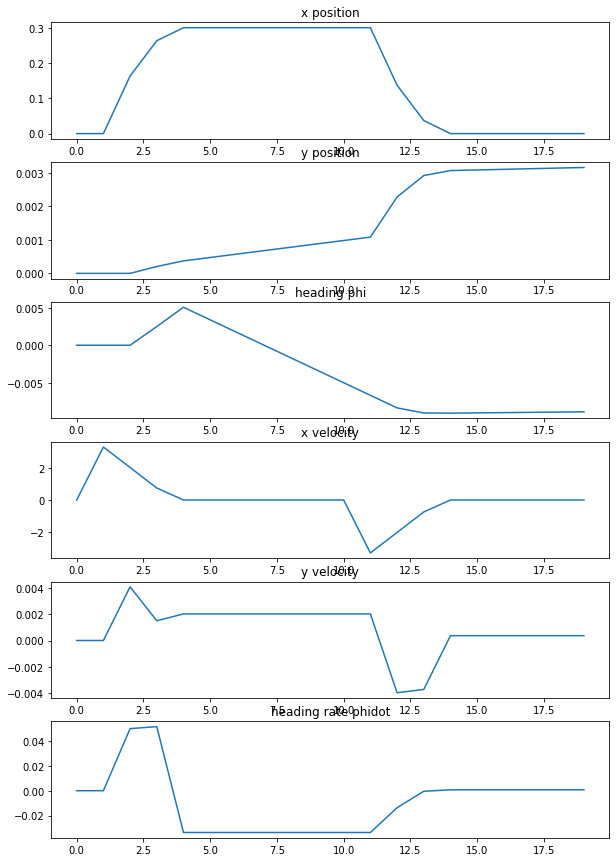

In [5]:
# Test that it slows down dynamics makes sense
dynamics.reset()
dt = dynamics.parameters["dt"]
s = dynamics.parameters["x0"]
mu = dynamics.parameters["mu"]
N = 19
state_dim = dynamics.ob_dim
action_dim = dynamics.u_dim
action_vector = np.zeros((action_dim, N))
state_vector = np.zeros((state_dim,N+1))
state_vector[:,0] = s
for k in range(N):
    if k == 0:
        action = [3, 0.01]
    elif k >= 1 and k<10:
        action = [0., 0.01]
    elif k==10:
        action = [-3,0.01]
    elif k>10:
        action = [0.,0.]
    print("k = ",k)
    state_vector[:,k+1] = dynamics.noiseless_transition(state_vector[:,k], action, dt, mu, True)

plt.figure(figsize=(10,15))
titles = ['x position', 'y position', 'heading phi', 'x velocity', 'y velocity', 'heading rate phidot']
for i in range(state_dim):
    plt.subplot(state_dim,1,i+1)
    plt.plot(state_vector[i,:])
    plt.title(titles[i])


In [6]:
kf_traj = np.load("track_data/L-track/L_track_points.npy")
track = Track(kf_traj)
track.fit_splines()

In [7]:
# full_track_points = np.load("/home/somrita/Documents/camelid/camelid/envs/racecar/track_data/full-track/race_track.npy")
# # full_track_points = np.load("/home/somrita/Documents/camelid/camelid/envs/racecar/track_data/full-track/race_track_detailed.npy")
# # print(np.shape(full_track_points))
# times = np.arange(start = 1, stop = np.shape(full_track_points)[0], step = 1)
# # track = Track(full_track_points, scale = 1.0, width = 20, isCCW = True, isLoop = True, laneSlack= 40)
# # track = Track(full_track_points, scale = 0.1)
# track = Track(full_track_points, times = times, scale = 1, width = 20) # works
# track = Track(full_track_points, times = times, scale = 1, width = 20, num_clusters = 40)
# track.fit_splines()

No handles with labels found to put in legend.


Local zero is at : [ 1.64364811e+00 -2.33566595e-04  6.42638079e-03]


(-3.0280517735768657, 4.125722281306194, -0.7265361767764464, 6.42907762784362)

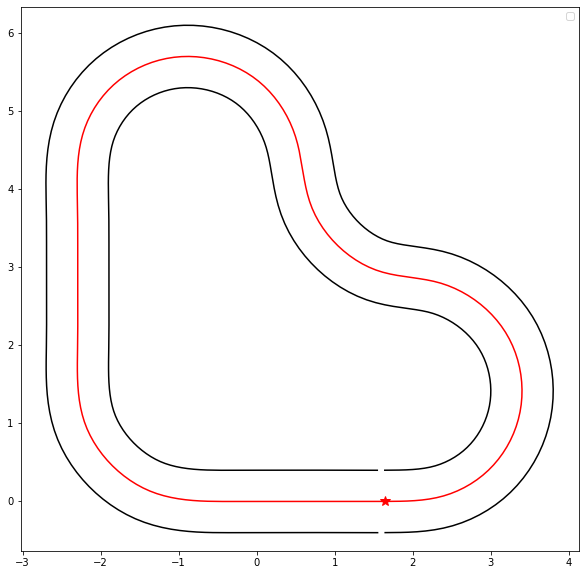

In [8]:
# Just plot track
plt.figure(figsize=(10,10))
track.plot_track()
# plt.plot(state_vector[0,:], state_vector[1,:],'-.', label = 'mu = 0.9')
# plt.plot(state_vector_mu_2[0,:], state_vector_mu_2[1,:],'-.', label = 'mu = 0.5')
# plt.plot(state_vector_mu_3[0,:], state_vector_mu_3[1,:],'-.', label = 'mu = 0.2')
zero = track.local_to_global(0,0,0)
print("Local zero is at :",zero)
plt.plot(zero[0], zero[1], "*r", markersize=10)
plt.legend()
plt.axis('equal')

In [9]:
def get_action(t):
    if t<=1:
        torque = 0.0
        steering_angle = 0.0
    elif t<=3:
        torque = 1.5
        steering_angle = 0.0
    else:
        torque = 0.0
        steering_angle = 0.0
    return np.array([torque, steering_angle])

In [10]:

verbose = True
dynamics.reset()
dt = dynamics.parameters["dt"]
N = (int)(100/dt)
state_dim = dynamics.ob_dim
action_dim = dynamics.u_dim
action_vector = np.zeros((action_dim, N))
state_vector = np.zeros((state_dim,N+1))
time_vector = np.zeros((N+1))
state_init = dynamics.parameters["x0"]
# # changing state_init
# state_init[0] = 50. 
# state_init[1] = 20.
# Initial state 
state_vector[:,0] = state_init

# # Other state vectors
# state_vector_mu_2 = np.zeros((state_dim,N+1))
# state_vector_mu_2[:,0] = state_init
# state_vector_mu_3 = np.zeros((state_dim,N+1))
# state_vector_mu_3[:,0] = state_init

# # Set up controller
# A, B, C = get_local_linearization(track, state_init, np.zeros(2), dynamics, is_local=False)
inital_cond_linearization = state_init 
inital_cond_linearization[3] = 0.4 # Needs to be greater than v_min_dyn to get Jacobian from delta --> state to be non-zero
A, B, C = get_local_linearization(track, inital_cond_linearization, [1., -0.01], dynamics, is_local=False)
if verbose:
  print("A: ",A)
  print("B: ",B)
  print("C: ",C)
N_mpc = 10
Q = np.zeros((6, 6))
Q[1,1] = 1 
Q[2,2] = 1
Q[3,3] = 1
Q = Q * 100
R = np.eye(2) * 0.4
vx_reference = 3

# state_constraint = np.array([1e6, track.halfWidth, np.pi / 2, 2 * vx_reference, 1, np.pi/2])
state_constraint = np.array([1e6, track.halfWidth, np.pi / 2, 2000 * vx_reference, 10000, np.pi/2])
state_constraints = (- state_constraint, state_constraint)

# input_constraint = np.array([4.5, np.pi / 6])
input_constraint = np.array([400000, np.pi/2])
input_constraints = ( - input_constraint, input_constraint)
controller = LTI_MPC_Controller(A, B, C, N_mpc, Q, R, vx_reference, state_constraints, input_constraints)


for k in tqdm(range(N)):
  if verbose: print("\n")
  if verbose: print("k:",k)
  t = k*dt 
  time_vector[k] = t
  
  # Using controller
  state_local = get_local_state(state_vector[:,k], track)
  action = controller.solve(state_local)
  action_vector[:,k] = action
  if verbose: print("Controller action: ",action)

  # # Using arbitrary actions
  # action = get_action(t)
  if verbose: print("Dynamics mu: ",dynamics.parameters["mu"])
  mu = dynamics.parameters["mu"]
  # mu_1 = 0.9
  state_vector[:,k+1] = dynamics.noiseless_transition(state_vector[:,k], action, dt, mu, False)
  if verbose: print("Resulting state: ",state_vector[:,k+1])
  # mu_2 = 0.5
  # state_vector_mu_2[:,k+1] = dynamics.noiseless_transition(state_vector_mu_2[:,k], action, dt, mu_2, False)
  # mu_3 = 0.2
  # state_vector_mu_3[:,k+1] = dynamics.noiseless_transition(state_vector_mu_3[:,k], action, dt, mu_3, False)
time_vector[N] = N*dt

  0%|          | 0/2000 [00:00<?, ?it/s]

A:  [[ 1.00000000e+00 -3.84174504e-06  5.11290890e-04 -4.94423411e-04
   1.27822723e-03  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00 -7.21513242e-03 -4.66329996e-02
  -1.80378310e-02  0.00000000e+00]
 [ 0.00000000e+00  2.72259692e-06  9.99637655e-01  3.50391721e-04
  -9.05863734e-04  5.00000000e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  -1.02375231e-02 -1.99631700e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.04748755e+00 -1.99900183e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   6.23529505e-04 -3.86344908e+00]]
B:  [[0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [1.51603357 0.00818988]
 [0.         0.40944632]
 [0.         4.98752938]]
C:  [ 9.97261521e-04 -1.39969629e-02 -5.66639962e-04 -1.26850530e+00
 -4.09500922e-07 -4.98819447e-06]


k: 0
infeasible


TypeError: 'NoneType' object is not subscriptable

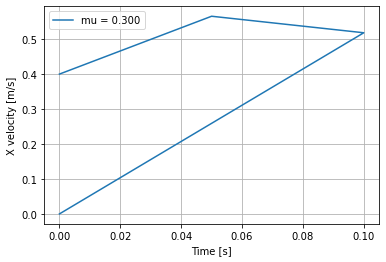

In [ ]:
plt.plot(time_vector,state_vector[3,:], label = 'mu = {:.3f}'.format(dynamics.parameters["mu"]))
# +str(dynamics.parameters["mu"]))
# plt.plot(time_vector,state_vector_mu_2[3,:], label = 'mu = 0.5')
# plt.plot(time_vector,state_vector_mu_3[3,:], label = 'mu = 0.2')
plt.xlabel('Time [s]')
plt.ylabel('X velocity [m/s]')
plt.grid('true')
plt.legend()

In [ ]:
state_vector[0,0:3]
state_vector[1,0:3]

array([20., 20., 20.])

[0.0, 0.0]


(-31.09350801259164, 275.5432209358295, -17.603484142926508, 223.441307510028)

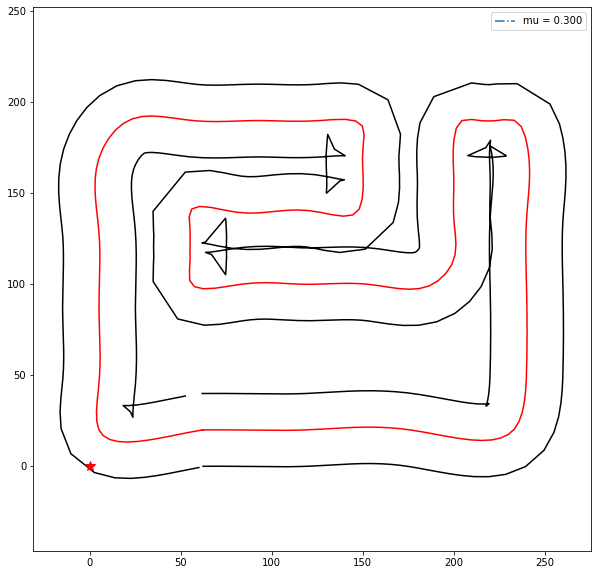

In [ ]:
plt.figure(figsize=(10,10))
track.plot_track()
plt.plot(state_vector[0,0:3], state_vector[1,0:3],'-.', label = 'mu = {:.3f}'.format(dynamics.parameters["mu"]))
# plt.plot(state_vector_mu_2[0,:], state_vector_mu_2[1,:],'-.', label = 'mu = 0.5')
# plt.plot(state_vector_mu_3[0,:], state_vector_mu_3[1,:],'-.', label = 'mu = 0.2')
# zero = track.local_to_global(0,0,0)
zero = [0.,0.]
print(zero)
plt.plot(zero[0], zero[1], "*r", markersize=10)
plt.legend()
plt.axis('equal')

Text(0.5, 0, 'Time step')

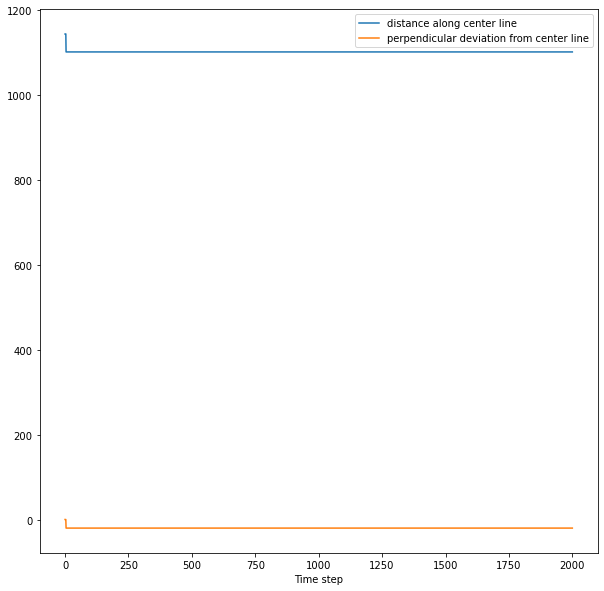

In [ ]:
state_vector_local = np.array([get_local_state(state_vector[:,t], track) for t in range(N+1)]).T
plt.figure(figsize=(10,10))
plt.plot(state_vector_local[0,:], label = 'distance along center line')
plt.plot(state_vector_local[1,:], label = 'perpendicular deviation from center line')
plt.legend()
plt.xlabel('Time step')

Text(0.5, 0, 'Time step')

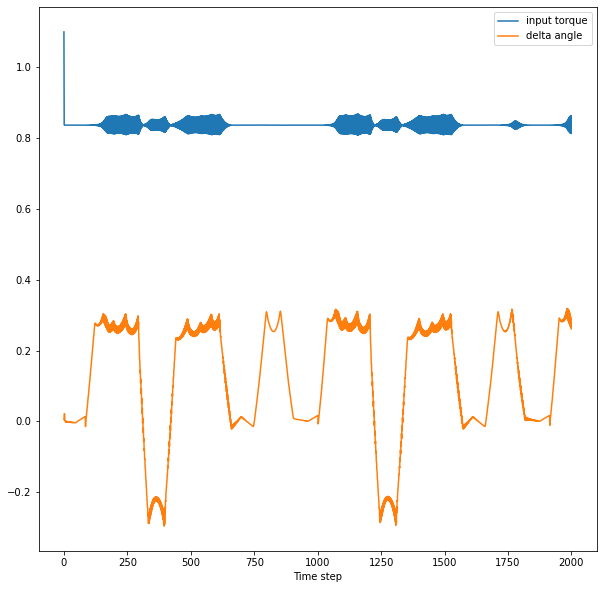

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(action_vector[0,:], label = 'input torque')
plt.plot(action_vector[1,:], label = 'delta angle')
plt.legend()
plt.xlabel('Time step')

# Trying to re-linearize at each time step

In [ ]:

verbose = True
dynamics.reset()
dt = dynamics.parameters["dt"]
N = (int)(50/dt)
# N = (int)(1/dt)

state_dim = dynamics.ob_dim
action_dim = dynamics.u_dim
action_vector = np.zeros((action_dim, N))
state_vector = np.zeros((state_dim,N+1))
time_vector = np.zeros((N+1))
time_vector = dt*np.arange(start = 0, stop = N+1, step = 1)
state_init = dynamics.parameters["x0"]
# changing state_init
state_init[0] = 50. 
state_init[1] = 20.
# Initial state 
state_vector[:,0] = state_init

# # Other state vectors
# state_vector_mu_2 = np.zeros((state_dim,N+1))
# state_vector_mu_2[:,0] = state_init
# state_vector_mu_3 = np.zeros((state_dim,N+1))
# state_vector_mu_3[:,0] = state_init

# # Set up controller
# A, B, C = get_local_linearization(track, state_init, np.zeros(2), dynamics, is_local=False)
inital_cond_linearization = state_init 
inital_cond_linearization[3] = 0.4 # Needs to be greater than v_min_dyn to get Jacobian from delta --> state to be non-zero
A, B, C = get_local_linearization(track, inital_cond_linearization, [1., -0.01], dynamics, is_local=False)
if verbose:
  print("A: ",A)
  print("B: ",B)
  print("C: ",C)
# N_mpc = 10
N_mpc = 20
Q = np.zeros((6, 6))
Q[1,1] = 1 
Q[2,2] = 1
Q[3,3] = 1
Q = Q * 100
R = np.eye(2) * 0.4
vx_reference = 0.4

# state_constraint = np.array([1e6, track.halfWidth, np.pi / 2, 2 * vx_reference, 1, np.pi/2])
state_constraint = np.array([1e6, track.halfWidth, np.pi / 2, 20000 * vx_reference, 1000000, np.pi/2])
state_constraints = (- state_constraint, state_constraint)

# input_constraint = np.array([4.5, np.pi / 6])
input_constraint = np.array([1e5, np.pi / 2])
input_constraints = ( - input_constraint, input_constraint)
controller = LTI_MPC_Controller(A, B, C, N_mpc, Q, R, vx_reference, state_constraints, input_constraints)


for k in tqdm(range(N)):
  if verbose: print("\n")
  if verbose: print("k:",k)
  t = k*dt 
  
  # Using controller
#   A, B, C = get_local_linearization(track, inital_cond_linearization, [1., -0.01], dynamics, is_local=False) # works
#   A, B, C = get_local_linearization(track, state_vector[:,k], [1., -0.01], dynamics, is_local=False) # doesn't work
#   sbar = state_vector[:,k]
#   sbar[3] = 0.4
#   A, B, C = get_local_linearization(track, sbar, [1., -0.01], dynamics, is_local=False) #doesn't work

#   sbar = state_vector[:,k]
# #   sbar[3] = 0.4
#   if k == 0:
#       ubar = [1., -0.01]
#   else:
#       ubar = action_vector[:,k-1]
#   A, B, C = get_local_linearization(track, sbar, ubar, dynamics, is_local=False)
  
  if k == 0:
      ubar = [1., -0.01]
  else:
      ubar = action_vector[:,k-1]
  A, B, C = get_local_linearization(track, state_vector[:,k], ubar, dynamics, is_local=False)

  controller = LTI_MPC_Controller(A, B, C, N_mpc, Q, R, vx_reference, state_constraints, input_constraints)
  state_local = get_local_state(state_vector[:,k], track)
  action = controller.solve(state_local)
  action_vector[:,k] = action
  if verbose: print("Controller action: ",action)

  # # Using arbitrary actions
  # action = get_action(t)
  if verbose: print("Dynamics mu: ",dynamics.parameters["mu"])
  mu = dynamics.parameters["mu"]
  # mu_1 = 0.9
  state_vector[:,k+1] = dynamics.noiseless_transition(state_vector[:,k], action, dt, mu, False)
  if verbose: print("Resulting state: ",state_vector[:,k+1])
  # mu_2 = 0.5
  # state_vector_mu_2[:,k+1] = dynamics.noiseless_transition(state_vector_mu_2[:,k], action, dt, mu_2, False)
  # mu_3 = 0.2
  # state_vector_mu_3[:,k+1] = dynamics.noiseless_transition(state_vector_mu_3[:,k], action, dt, mu_3, False)


  0%|          | 0/1000 [00:00<?, ?it/s]

A:  [[ 1.00000000e+00 -1.67665191e-05  3.93777628e-03  4.89250980e-02
   9.84444070e-03  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  1.96070207e-02 -9.86304371e-03
   4.90175516e-02  0.00000000e+00]
 [ 0.00000000e+00 -1.43917641e-08  1.00000338e+00  4.19955070e-05
   8.45010628e-06  5.00000000e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  -1.02375231e-02 -1.99631700e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.04748755e+00 -1.99900183e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   6.23529505e-04 -3.86344908e+00]]
B:  [[0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [1.51603357 0.00818988]
 [0.         0.40944632]
 [0.         4.98752938]]
C:  [-1.87512304e-02  3.89339922e-03  1.09371350e-06 -1.26850530e+00
 -4.09500922e-07 -4.98819447e-06]


k: 0


  0%|          | 1/1000 [00:00<04:11,  3.97it/s]

Controller action:  [ 1.0746293  -0.31494378]
Dynamics mu:  0.3
Resulting state:  [50.02       20.          0.          0.72067712 -0.12262828 -1.49375414]


k: 1


  0%|          | 3/1000 [00:00<03:33,  4.67it/s]

Controller action:  [ 0.523499   -0.75009518]
Dynamics mu:  0.3
Resulting state:  [50.05603386 19.99386859 -0.07468771  0.19106986 -0.2314799  -1.18189928]


k: 2
All derivs here 0
Controller action:  [ 0.53974655 -0.        ]
Dynamics mu:  0.3
Resulting state:  [50.06469708 19.98161399 -0.13378267  0.         -0.22018864 -1.18189928]


  0%|          | 4/1000 [00:00<03:27,  4.81it/s]



k: 3
All derivs here 0
dTauNet_dTauDrive is 0
Controller action:  [-0. -0.]
Dynamics mu:  0.3
Resulting state:  [ 5.00632286e+01  1.99707029e+01 -1.92877635e-01  1.30120396e-02
 -2.20188638e-01 -1.18189928e+00]


k: 4
All derivs here 0


  1%|          | 6/1000 [00:01<03:40,  4.50it/s]

Controller action:  [ 0.1697114 -0.       ]
Dynamics mu:  0.3
Resulting state:  [50.06175681 19.95977294 -0.2519726   0.         -0.21941969 -1.18189928]


k: 5
All derivs here 0
dTauNet_dTauDrive is 0
Controller action:  [0. 0.]
Dynamics mu:  0.3
Resulting state:  [ 5.00590216e+01  1.99491484e+01 -3.11067562e-01  1.29665988e-02
 -2.19419692e-01 -1.18189928e+00]


k: 6
All derivs here 0


  1%|          | 8/1000 [00:01<03:15,  5.06it/s]

Controller action:  [0.33270705 0.        ]
Dynamics mu:  0.3
Resulting state:  [50.05628085 19.9385055  -0.37016253  0.         -0.21865343 -1.18189928]


k: 7
All derivs here 0
dTauNet_dTauDrive is 0
Controller action:  [0. 0.]
Dynamics mu:  0.3
Resulting state:  [ 5.00523258e+01  1.99283133e+01 -4.29257490e-01  1.29213166e-02
 -2.18653431e-01 -1.18189928e+00]


k: 8
All derivs here 0


  1%|          | 8/1000 [00:01<03:51,  4.28it/s]

infeasible


TypeError: 'NoneType' object is not subscriptable

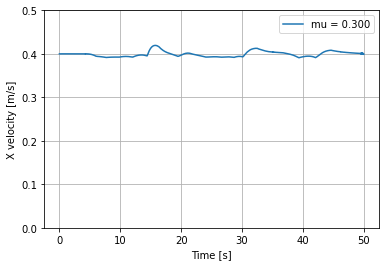

In [ ]:
plt.plot(time_vector,state_vector[3,:], label = 'mu = {:.3f}'.format(dynamics.parameters["mu"]))
# +str(dynamics.parameters["mu"]))
# plt.plot(time_vector,state_vector_mu_2[3,:], label = 'mu = 0.5')
# plt.plot(time_vector,state_vector_mu_3[3,:], label = 'mu = 0.2')
plt.ylim([0.0,0.5])
plt.xlabel('Time [s]')
plt.ylabel('X velocity [m/s]')
plt.grid('true')
plt.legend()

[0.0, 0.0]


(-3.0280517735768657, 4.125722281306194, -0.7265361767764464, 6.42907762784362)

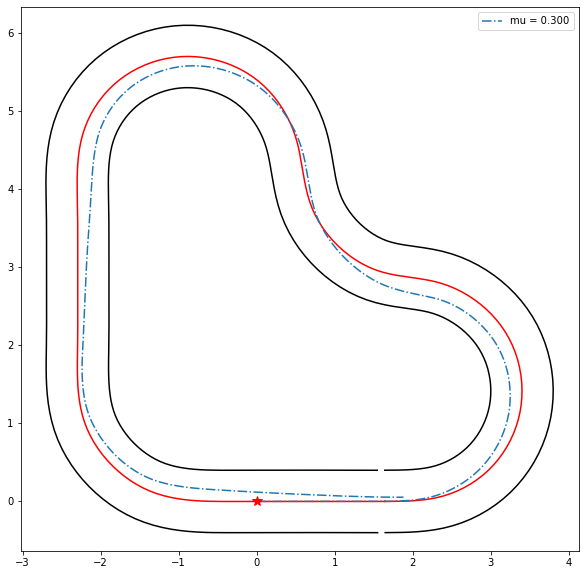

In [ ]:
plt.figure(figsize=(10,10))
track.plot_track()
plt.plot(state_vector[0,:], state_vector[1,:],'-.', label = 'mu = {:.3f}'.format(dynamics.parameters["mu"]))
# plt.plot(state_vector_mu_2[0,:], state_vector_mu_2[1,:],'-.', label = 'mu = 0.5')
# plt.plot(state_vector_mu_3[0,:], state_vector_mu_3[1,:],'-.', label = 'mu = 0.2')
# zero = track.local_to_global(0,0,0)
zero = [0.,0.]
print(zero)
plt.plot(zero[0], zero[1], "*r", markersize=10)
plt.legend()
plt.axis('equal')

Text(0.5, 0, 'Time step')

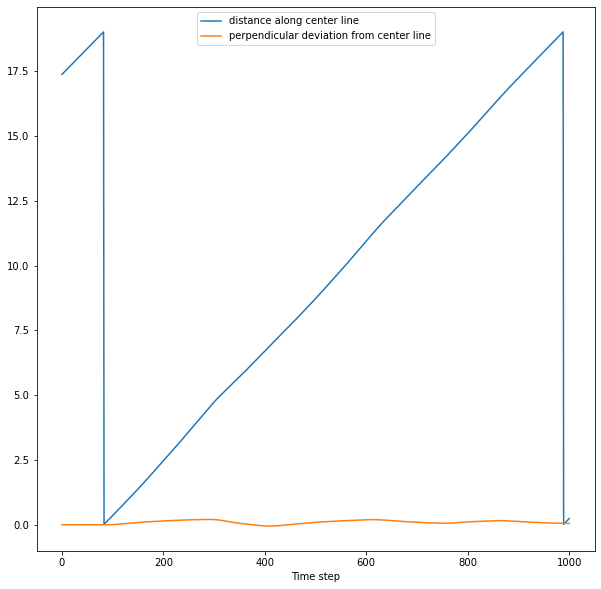

In [ ]:
state_vector_local = np.array([get_local_state(state_vector[:,t], track) for t in range(N+1)]).T
plt.figure(figsize=(10,10))
plt.plot(state_vector_local[0,:], label = 'distance along center line')
plt.plot(state_vector_local[1,:], label = 'perpendicular deviation from center line')
plt.legend()
plt.xlabel('Time step')

Text(0.5, 0, 'Time step')

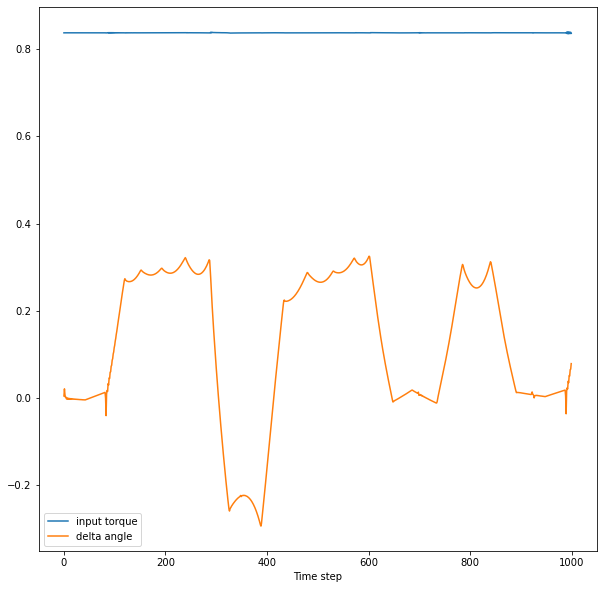

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(action_vector[0,:], label = 'input torque')
plt.plot(action_vector[1,:], label = 'delta angle')
plt.legend()
plt.xlabel('Time step')

In [ ]:
action_vector[1,:]

array([0.00517778, 0.02171398, 0.00692859, ..., 0.        , 0.        ,
       0.        ])

# Trying min time controller

In [ ]:

verbose = False
dynamics.reset()
dt = dynamics.parameters["dt"]
N = (int)(50/dt)
# N = (int)(1/dt)

state_dim = dynamics.ob_dim
action_dim = dynamics.u_dim
action_vector = np.zeros((action_dim, N))
state_vector = np.zeros((state_dim,N+1))
time_vector = np.zeros((N+1))
time_vector = dt*np.arange(start = 0, stop = N+1, step = 1)
state_init = dynamics.parameters["x0"]
# Initial state 
state_vector[:,0] = state_init

# # Set up controller
inital_cond_linearization = state_init 
inital_cond_linearization[3] = 0.4 # Needs to be greater than v_min_dyn to get Jacobian from delta --> state to be non-zero
A, B, C = get_local_linearization(track, inital_cond_linearization, [1., -0.01], dynamics, is_local=False)
if verbose:
  print("A: ",A)
  print("B: ",B)
  print("C: ",C)
# N_mpc = 10
N_mpc = 20
Q = np.zeros((6, 6))
Q[1,1] = 1e-1
Q[2,2] = 1e-1
Q[3,3] = 1e-1
Q = Q * 100
R = np.eye(2) * 0.4
vx_reference = 0.4
W_sdot = 100

# state_constraint = np.array([1e6, track.halfWidth, np.pi / 2, 2 * vx_reference, 1, np.pi/2])
state_constraint = np.array([1e6, track.halfWidth, np.pi / 2, 2000 * vx_reference, 1, np.pi/2])
state_constraints = (- state_constraint, state_constraint)

input_constraint = np.array([4.5, np.pi / 6])
input_constraints = ( - input_constraint, input_constraint)
# controller = LTI_MPC_Controller(A, B, C, N_mpc, Q, R, vx_reference, state_constraints, input_constraints)
controller = Min_Time_Controller(A, B, C, N_mpc, Q, R, vx_reference, state_constraints, input_constraints, track, W_sdot)


for k in tqdm(range(N)):
  if verbose: print("\n")
  if verbose: print("k:",k)
  t = k*dt 
  
  # Using controller  
  if k == 0:
      ubar = [1., -0.01]
  else:
      ubar = action_vector[:,k-1]
  A, B, C = get_local_linearization(track, state_vector[:,k], ubar, dynamics, is_local=False)

  # controller = LTI_MPC_Controller(A, B, C, N_mpc, Q, R, vx_reference, state_constraints, input_constraints)
  controller = Min_Time_Controller(A, B, C, N_mpc, Q, R, vx_reference, state_constraints, input_constraints, track, W_sdot)

  state_local = get_local_state(state_vector[:,k], track)
  action = controller.solve(state_local)
  action_vector[:,k] = action
  if verbose: print("Controller action: ",action)

  # # Using arbitrary actions
  # action = get_action(t)
  if verbose: print("Dynamics mu: ",dynamics.parameters["mu"])
  mu = dynamics.parameters["mu"]
  state_vector[:,k+1] = dynamics.noiseless_transition(state_vector[:,k], action, dt, mu, False)
  if verbose: print("Resulting state: ",state_vector[:,k+1])


  1%|          | 7/1000 [00:01<03:56,  4.20it/s]

Added track length to x_c_local


  4%|▍         | 45/1000 [00:11<04:01,  3.95it/s]


TypeError: 'NoneType' object is not subscriptable

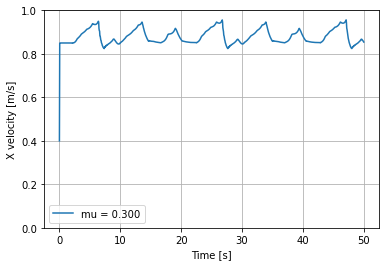

In [ ]:
plt.plot(time_vector,state_vector[3,:], label = 'mu = {:.3f}'.format(dynamics.parameters["mu"]))
plt.xlabel('Time [s]')
plt.ylabel('X velocity [m/s]')
plt.grid('true')
plt.ylim([0.0,1.0])
plt.legend()

(-3.0280517735768657, 4.125722281306194, -0.7265361767764464, 6.42907762784362)

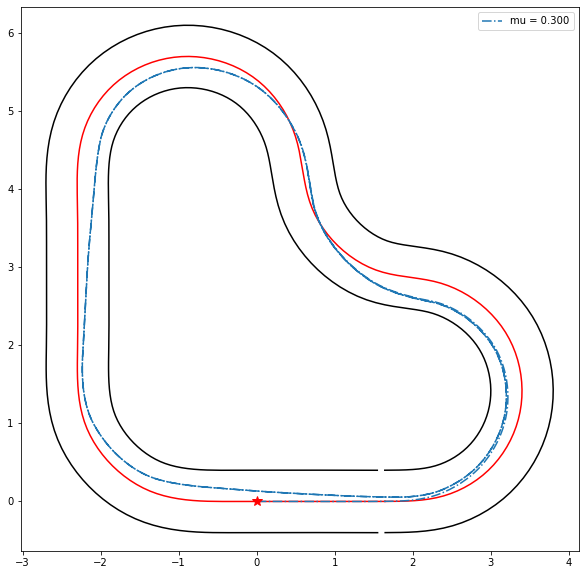

In [ ]:
plt.figure(figsize=(10,10))
track.plot_track()
plt.plot(state_vector[0,:], state_vector[1,:],'-.', label = 'mu = {:.3f}'.format(dynamics.parameters["mu"]))
zero = [0.,0.]
plt.plot(zero[0], zero[1], "*r", markersize=10)
plt.legend()
plt.axis('equal')

Text(0.5, 0, 'Time step')

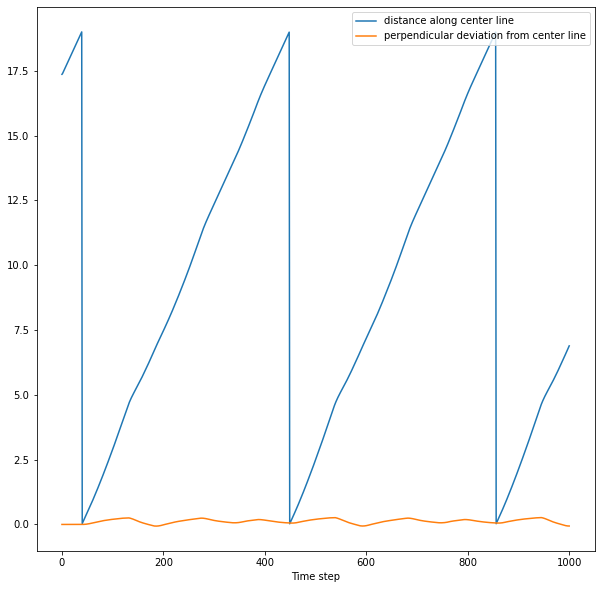

In [ ]:
state_vector_local = np.array([get_local_state(state_vector[:,t], track) for t in range(N+1)]).T
plt.figure(figsize=(10,10))
plt.plot(state_vector_local[0,:], label = 'distance along center line')
plt.plot(state_vector_local[1,:], label = 'perpendicular deviation from center line')
plt.legend()
plt.xlabel('Time step')

Text(0.5, 0, 'Time step')

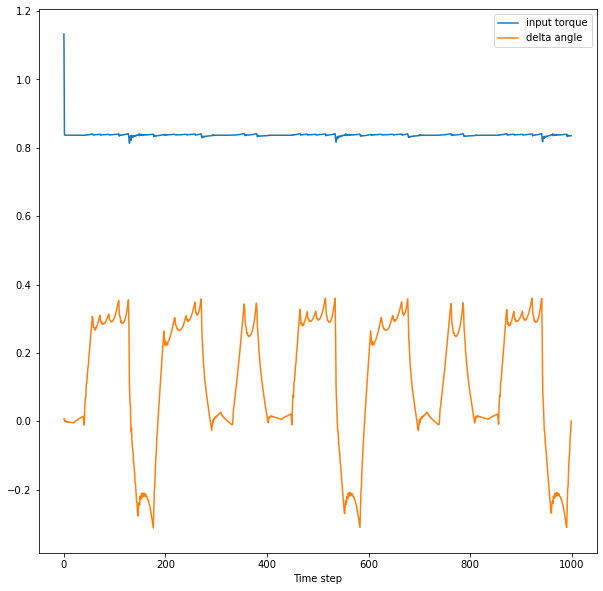

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(action_vector[0,:], label = 'input torque')
plt.plot(action_vector[1,:], label = 'delta angle')
plt.legend()
plt.xlabel('Time step')

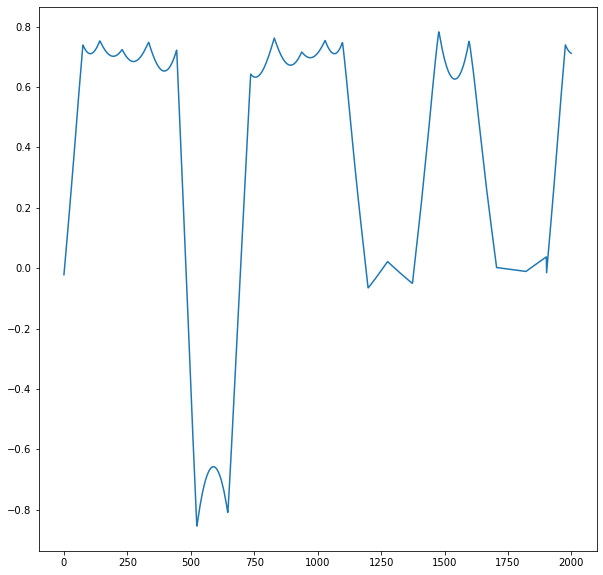

In [ ]:
s_values = np.arange(start = 0, step = 0.01, stop = 20) 
curv_values = [track.get_curvature(s) for s in s_values]
plt.figure(figsize=(10,10))
plt.plot(curv_values)